In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/mehdi/github/LSSutils')
import fitsio as ft
from lssutils.lab import AnaFast, MeanDensity
import healpy as hp
import lssutils.utils as ut
from lssutils.extrn.galactic import hpmaps
from glob import glob
from lssutils.dataviz import setup_color


setup_color()
af = AnaFast()

In [2]:
def run_nbar(ng, nr, mask, syst, selection=None):
    nb = MeanDensity(ng, nr, mask, syst, selection=selection)
    nb.run()
    return nb.output

def read_wnn(path2file):
    w_ = ft.read(path2file)
    #w_nn_ = np.median(w_['weight'], axis=1)
    w_nn = w_['weight'] / np.median(w_['weight'])
    w_nn = w_nn.clip(0.5, 2.0)
    return ut.make_hp(1024, w_['hpix'], w_nn, True)

def read_table(path2file):
    d_ = ft.read(path2file)
    ng = ut.make_hp(1024, d_['hpix'], d_['label'])
    nr = ut.make_hp(1024, d_['hpix'], d_['fracgood'])
    mask = ut.make_hp(1024, d_['hpix'], 1.0) > 0.5
    syst = ut.make_hp(1024, d_['hpix'], np.log(d_['features'][:, 0]))
    return ng, nr, mask, syst

def run_af(ng, nr, mask, syst, selection=None):
    dg = ut.make_overdensity(ng, nr, mask, selection_fn=selection)
    ds = ut.make_overdensity(syst, nr, mask, is_sys=True)
    
    cgg = af(dg, nr, mask)
    cgs = af(dg, nr, mask, map2=ds, weight2=nr, mask2=mask)
    css = af(ds, nr, mask)
    
    return (cgg, cgs, css)

In [4]:
bmzls = read_table('/home/mehdi/data/rongpu/imaging_sys/tables/nelg_features_bmzls_1024.fits')

wnn_list = glob('/home/mehdi/data/tanveer/dr9/elg_mse_snapshots/bmzls/windows/wind*fits')
print(len(wnn_list))
wnn = []
for wnn_i in wnn_list[:50]:
    wnn.append(read_wnn(wnn_i))
    print('.', end='')
    
wnn_m = np.array(wnn).mean(axis=0)

1000
..................................................

In [6]:
cls = {}
cls['BMZLS (before)'] = run_af(bmzls[0], bmzls[1], bmzls[2], bmzls[3])
cls['BMZLS (after)'] = run_af(bmzls[0], bmzls[1], bmzls[2], bmzls[3], selection=wnn_m)

(1e-12, 1.0)

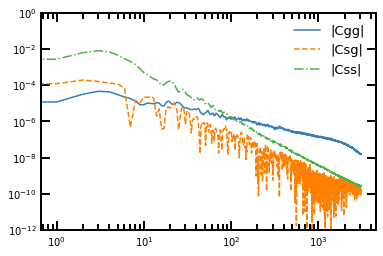

In [7]:
for i, label in zip([0, 1, 2], ['Cgg', 'Csg', 'Css']):
    plt.loglog(abs(cls['BMZLS (after)'][i]['cl']), label=f'|{label}|')
plt.legend()
plt.ylim(1.0e-12, 1.0e0)

(1e-12, 1.0)

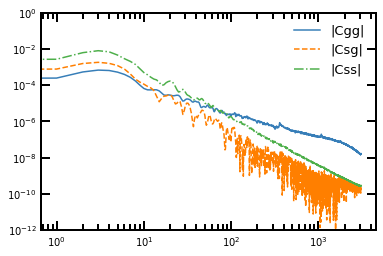

In [8]:
for i, label in zip([0, 1, 2], ['Cgg', 'Csg', 'Css']):
    plt.loglog(abs(cls['BMZLS (before)'][i]['cl']), label=f'|{label}|')
plt.legend()
plt.ylim(1.0e-12, 1.0e0)

In [9]:
dt = ft.read('/home/mehdi/data/rongpu/imaging_sys/tables/nelg_features_bmzls_1024.fits')

In [10]:
Css = []


nran = ut.make_hp(1024, dt['hpix'], dt['fracgood'])
mask = ut.make_hp(1024, dt['hpix'], 1.0) > 0.5

for i in range(13):
    sys_i = ut.make_hp(1024, dt['hpix'], dt['features'][:, i])
    del_i = ut.make_overdensity(sys_i, nran, mask, is_sys=True)
    Css.append(af(sys_i, nran, mask))
    print('.', end='')

.............

(1e-12, 10000000.0)

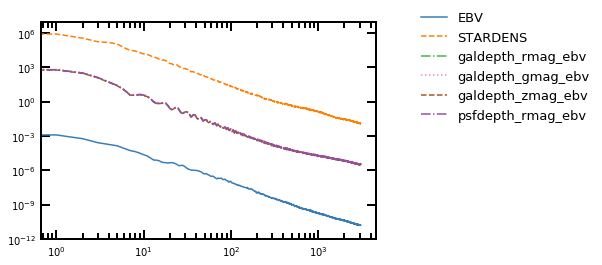

In [14]:
for i, Css_i in enumerate(Css):
    if i < 6:
        plt.loglog(Css_i['cl'], label=ut.maps_dr9[i])
plt.legend(bbox_to_anchor=(1.1, 1.1))
plt.ylim(1.0e-12, 1.0e7)

(1e-12, 10000000.0)

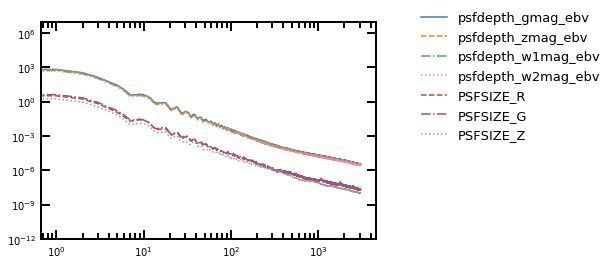

In [15]:
for i, Css_i in enumerate(Css):
    if i >= 6:
        plt.loglog(Css_i['cl'], label=ut.maps_dr9[i])
plt.legend(bbox_to_anchor=(1.1, 1.1))
plt.ylim(1.0e-12, 1.0e7)

fsky:  0.12338479359944661


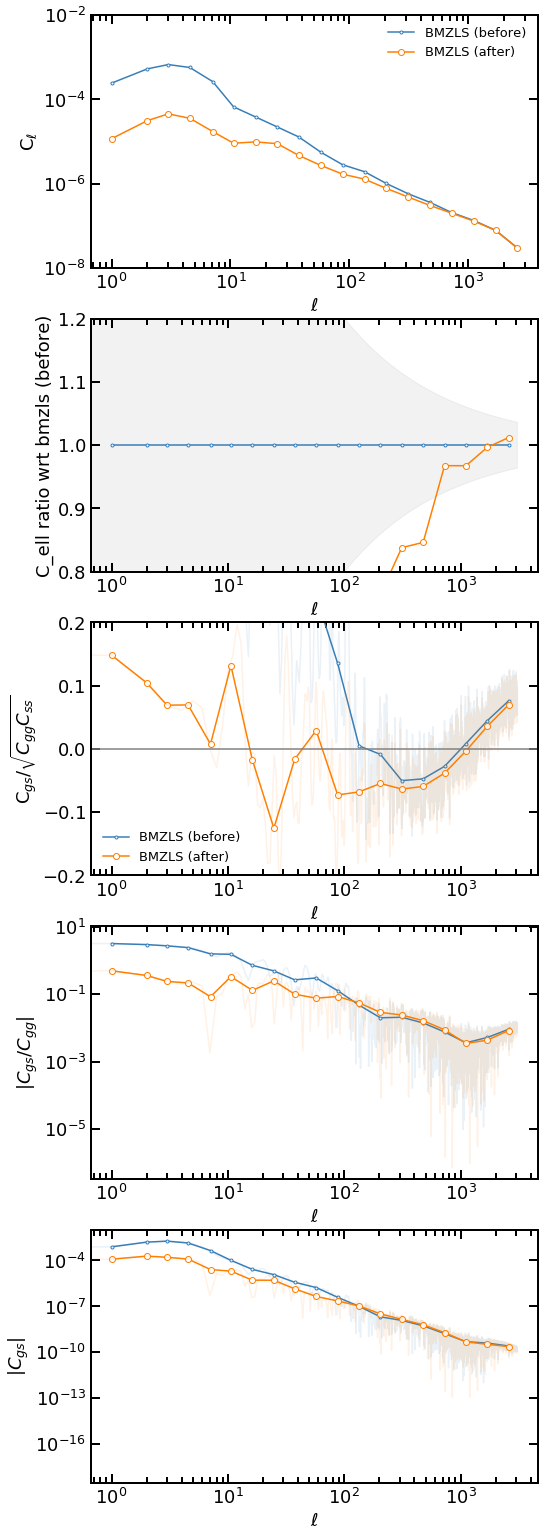

In [41]:
fsky = bmzls[2].mean()
print('fsky: ', fsky)

def add_cgg(cls, scaling='log'):
    
    fg, ax = plt.subplots(nrows=5, figsize=(8, 27))
    ax = ax.flatten()
    ref = 'BMZLS (before)'#'BASS/MzLS  (Wsys BMZLS S)'
    
    if scaling =='log':
        lbins = np.logspace(0, np.log10(3080), 20)
    elif scaling == 'linear':
        lbins = np.arange(1., 3073., 100)
    else:
        raise ValueError()
    lb_, clb_ = ut.histogram_cell(cls[ref][0]['cl'], bins=lbins)


    le = np.arange(cls[ref][0]['cl'].size)
    err = 1./np.sqrt((2.*le+1.)*fsky)
    
    mk = ['.', 'o', 's', '^', '*', '+']
    color = ['C0', 'C1']
    
    for i, (ni, cli) in enumerate(cls.items()):
        
        
        lsi = '--' if 'Wsys' in ni else '-' 
        kw = dict(ls=lsi, marker=mk[i],color=color[i], mfc='w')
        kw2 = dict(ls=lsi, alpha=0.1, color=color[i])
        
        lb, clb = ut.histogram_cell(cli[0]['cl'], bins=lbins)
        ax[0].plot(lb, clb, label=f'{ni}', **kw)
            
        lb, clb = ut.histogram_cell(cli[0]['cl'], bins=lbins)
        ax[1].plot(lb, clb/clb_, label=f'{ni}', **kw)
        
        clr_ = cli[1]['cl']/np.sqrt(cls['BMZLS (before)'][0]['cl']*cls['BMZLS (before)'][2]['cl'])
        lbr, clr = ut.histogram_cell(clr_, bins=lbins)
        ax[2].plot(lbr, clr, label=f'{ni}', **kw)
        ax[2].plot(clr_, **kw2)
        
        clr_2 = abs(cli[1]['cl']/cls['BMZLS (before)'][0]['cl'])
        lbr, clx = ut.histogram_cell(clr_2, bins=lbins)
        ax[3].plot(lbr, clx, label=f'{ni}', **kw)
        ax[3].plot(clr_2, **kw2)

        clr_3 = abs(cli[1]['cl'])
        lbr, clx = ut.histogram_cell(clr_3, bins=lbins)
        ax[4].plot(lbr, clx, label=f'{ni}', **kw)
        ax[4].plot(clr_3, **kw2)

        

    ax[1].fill_between(le, 1-err, 1+err, alpha=0.1, 
                       color='grey', label=r'1/sqrt[(2$\ell$+1)fsky]')
    #ax[3].plot(le, cls[ref][0]['cl']*err, color='k', alpha=0.2)
    
    ax[2].axhline(0.0, ls='-', color='grey')

    ax[0].legend()    
    ax[2].legend()
    ax[0].set(ylim=(1.0e-8, 1.0e-2), xlabel=r'$\ell$', ylabel=r'C$_{\ell}$', yscale='log', xscale=scaling)
    
    ax[1].set(ylim=(0.8, 1.2),  xlabel=r'$\ell$', ylabel=r'C_ell ratio wrt bmzls (before)', xscale=scaling)   
    ax[2].set(xlabel=r'$\ell$', ylabel=r'C$_{gs}/\sqrt{C_{gg}C_{ss}}$', xscale=scaling, ylim=(-0.2, 0.2))
    ax[3].set(xlabel=r'$\ell$', ylabel=r'$|C_{gs}/C_{gg}|$', yscale='log', xscale=scaling)
    ax[4].set(xlabel=r'$\ell$', ylabel=r'$|C_{gs}|$', yscale='log', xscale=scaling)

    
add_cgg(cls, 'log')

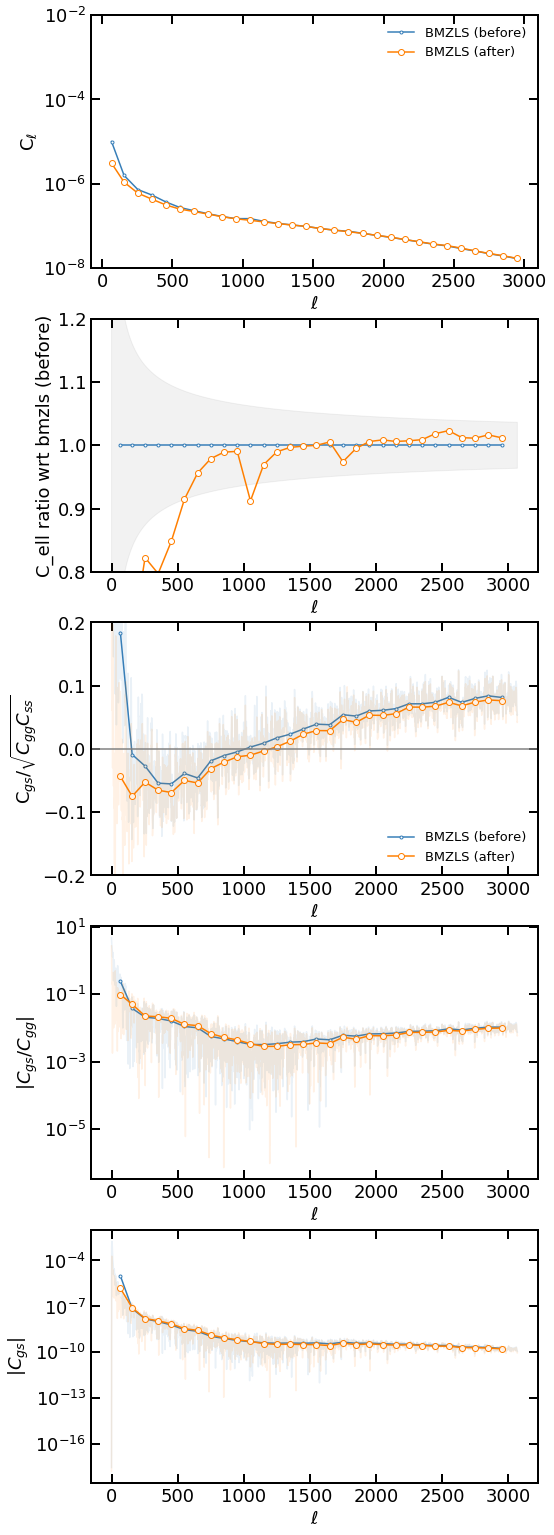

In [42]:
add_cgg(cls, 'linear')

fsky:  0.12338479359944661


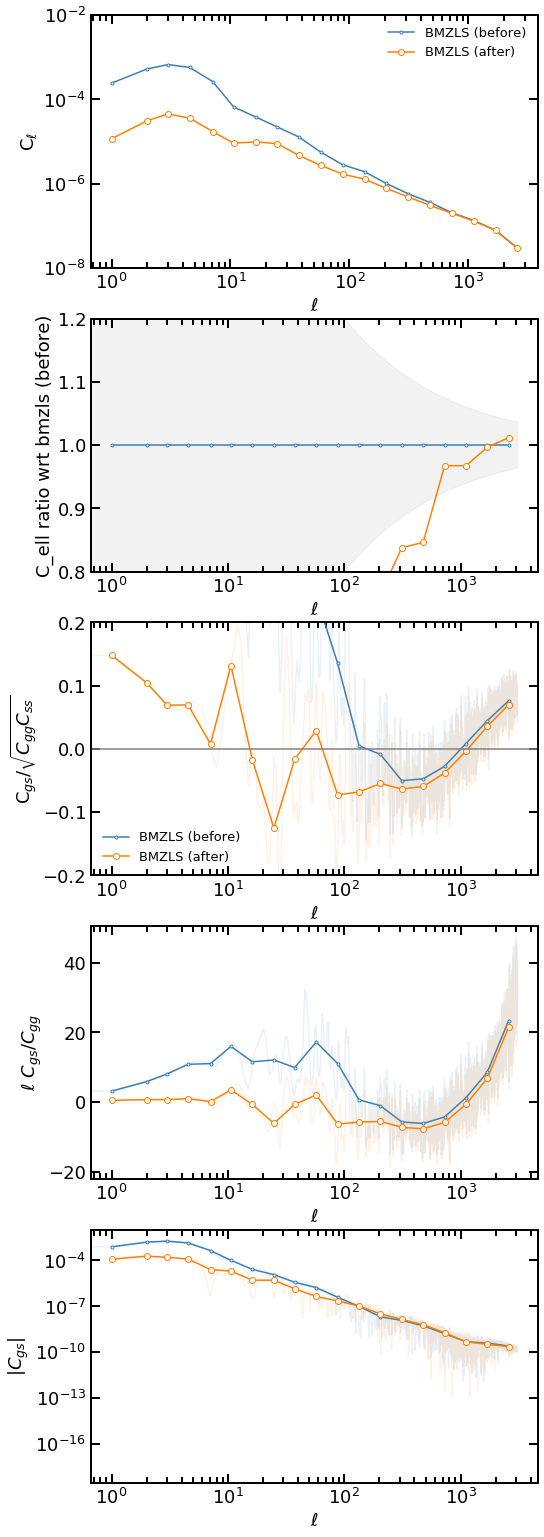

In [45]:
fsky = bmzls[2].mean()
print('fsky: ', fsky)

def add_cgg(cls, scaling='log'):
    
    fg, ax = plt.subplots(nrows=5, figsize=(8, 27))
    ax = ax.flatten()
    ref = 'BMZLS (before)'#'BASS/MzLS  (Wsys BMZLS S)'
    
    if scaling =='log':
        lbins = np.logspace(0, np.log10(3080), 20)
    elif scaling == 'linear':
        lbins = np.arange(1., 3072., 100)
    else:
        raise ValueError()
    lb_, clb_ = ut.histogram_cell(cls[ref][0]['cl'], bins=lbins)


    le = np.arange(cls[ref][0]['cl'].size)
    err = 1./np.sqrt((2.*le+1.)*fsky)
    
    mk = ['.', 'o', 's', '^', '*', '+']
    color = ['C0', 'C1']
    
    for i, (ni, cli) in enumerate(cls.items()):
        
        
        lsi = '--' if 'Wsys' in ni else '-' 
        kw = dict(ls=lsi, marker=mk[i],color=color[i], mfc='w')
        kw2 = dict(ls=lsi, alpha=0.1, color=color[i])
        
        lb, clb = ut.histogram_cell(cli[0]['cl'], bins=lbins)
        ax[0].plot(lb, clb, label=f'{ni}', **kw)
            
        lb, clb = ut.histogram_cell(cli[0]['cl'], bins=lbins)
        ax[1].plot(lb, clb/clb_, label=f'{ni}', **kw)
        
        clr_ = cli[1]['cl']/np.sqrt(cls['BMZLS (before)'][0]['cl']*cls['BMZLS (before)'][2]['cl'])
        lbr, clr = ut.histogram_cell(clr_, bins=lbins)
        ax[2].plot(lbr, clr, label=f'{ni}', **kw)
        ax[2].plot(clr_, **kw2)
        
        clr_2 = cli[1]['cl']/cls['BMZLS (before)'][0]['cl']
        el = np.arange(clr_2.size)
        
        lbr, clx = ut.histogram_cell(clr_2, bins=lbins)
        ax[3].plot(lbr, lbr*clx, label=f'{ni}', **kw)
        ax[3].plot(el*clr_2, **kw2)

        clr_3 = abs(cli[1]['cl'])
        lbr, clx = ut.histogram_cell(clr_3, bins=lbins)
        ax[4].plot(lbr, clx, label=f'{ni}', **kw)
        ax[4].plot(clr_3, **kw2)

        

    ax[1].fill_between(le, 1-err, 1+err, alpha=0.1, 
                       color='grey', label=r'1/sqrt[(2$\ell$+1)fsky]')
    #ax[3].plot(le, cls[ref][0]['cl']*err, color='k', alpha=0.2)
    
    ax[2].axhline(0.0, ls='-', color='grey')

    ax[0].legend()    
    ax[2].legend()
    ax[0].set(ylim=(1.0e-8, 1.0e-2), xlabel=r'$\ell$', ylabel=r'C$_{\ell}$', yscale='log', xscale=scaling)
    
    ax[1].set(ylim=(0.8, 1.2),  xlabel=r'$\ell$', ylabel=r'C_ell ratio wrt bmzls (before)', xscale=scaling)   
    ax[2].set(xlabel=r'$\ell$', ylabel=r'C$_{gs}/\sqrt{C_{gg}C_{ss}}$', xscale=scaling, ylim=(-0.2, 0.2))
    ax[3].set(xlabel=r'$\ell$', ylabel=r'$\ell~C_{gs}/C_{gg}$', yscale='linear', xscale=scaling)
    ax[4].set(xlabel=r'$\ell$', ylabel=r'$|C_{gs}|$', yscale='log', xscale=scaling)

    
add_cgg(cls, 'log')

In [ ]:
## Conclusion
# It seems like the NN approach is not learning beyond ell > 300 (i.e., NSIDE/3)
# Changing the loss function is an option
# Look into the power spectra of the templates
# Change the depth of the neural network (e.g., with NSIDE=256)
# Create Gausssian mocks with HEALPIX to get Csg for 
# these mocks and get a sense of the significance of the remaining systematics

#Can we include the cross power in our loss function? 
# e.g., as a regularization
# it's ok to compute these cross-statistics over mini-batches.
# the term should be something like: C^{t}_gs Cov^-1 C_gs, Cov = 1/[(2el+1)fsky] (C_gg+1/nbar)^2 
# try with a lower NSIDE

# TODO: 
# 1. Find out what subset of these correlate with the Sag. stream
# 2. Cross correlation between the mitigated and imaging C_ell^{g,s} and (C_s,g)^2 / (C_g,g * C_s,s)


# TODO: diagnostics on the chains
# 1. Corner plot to see the correlation between the different parameters
# 2. Rank plot
# 3. Find the best fit and covariance, use those to initialize the starting points
# (make sure these are inside the priors)
# 4. scale the label (y)